# SBTi-Finance Tool for Temperature Scoring & Portfolio Coverage
## Do you want to understand what drives the temperature score of your portfolio to make better engagement and investment decisions?

![ExampleGraphs](https://github.com/OFBDABV/SBTi/raw/master/examples/images/JN_HeroImage.jpg)

This notebook provides some examples of how to use the SBTi-Finance Tool to analyse portfolios' and companies' GHG emissions
reduction targets.

The notebook is not intended as a production tool, but for you to be able to evaluate if this tool can fit with your objectives
 and workflow. The open source code for the tool is available at https://github.com/OFBDABV/SBTi, which should allow you
 to integrate it into your environment and then use as a production tool. A number of commercial data and services providers,
 such as CDP, Bloomberg, ISS, MSCI, TruCost, Urgentem and Ortec Finance are buidling or are considering providing solutions
 based on the open-source code or the methodology.

This notebook combines text and code to provide a testing environment for your research, to give you and understanding of
how the tool can help you analyse companies' and portfolios' temperature scores, to aid your engagement and investment decisions.

The notebook is loaded with example data, but you can also use your own data. For your first test, you can simply run the
code cells one by one in the current sequence, to get an understanding of how it works.

To run the code in a notebook, simply click on a cell and press SHIFT+ENTER or click the black "Play/Run cell" button in
between the brackets [ ] (hover over it with your mouse) in the upper left hand corner of each code cell.

Beware of the order in which you run the cells - if you do not follow the order below, you may run into errors. In that
case, start again from the top.

If you are not familiar with Notebooks, please refer to [this introduction](https://colab.research.google.com/notebooks/basic_features_overview.ipynb).

# Introduction to temperature scoring and portfolio coverage methods

Three methods are currently supported by the [SBTi](https://sciencebasedtargets.org/financial-institutions) for setting
targets on scope 3 portfolio emissions: the Sectoral Decarbonization Approach (SDA), the SBT Portfolio Coverage, and the
SBT Temperature Scoring. The latter two methods, Portfolio Coverage and Temperature Scoring, require assessing the targets
disclosed by the companies within a financial institution's portfolio.

Financial institutions may use the portfolio coverage and/or [temperature scoring methods](https://sciencebasedtargets.org/wp-content/uploads/2020/07/Temperature-Scoring-Beta-Methodology.pdf)
to set targets for their corporate instruments, including corporate debt, listed equity and bonds, and private equity and
debt (See relevant “Required Activities” in Table 5-2 of the [SBTi guidance](https://sciencebasedtargets.org/wp-content/uploads/2020/07/Temperature-Scoring-Beta-Methodology.pdf)
to drive adoption of science-based targets).

To use the *portfolio coverage method*, financial institutions commit to engaging with their investees to set their own
approved science-based targets, such that the financial institution is on a linear path to 100% SBT portfolio coverage by
2040. As the fulfillment of portfolio coverage targets mean that investees’ SBTs have been approved by SBTi, the 2040 timeline
has been determined to allow companies enough time to implement their target to ultimately achieve an economy-wide transition
to net zero by 2050.

To use the *temperature scoring method*, financial iinstitutions determine the current temperature score of their portfolio
based on the public GHG emission reduction targets of their investees (these targets include SBTs and any other valid public
GHG targets that meet the method criteria). Financial institutions set targets to align their base year portfolio temperature
score to a long-term temperature goal (e.g. 2°C, well-below 2°C, 1.5°C).
The temperature scoring method is an open source framework to enable the translation of corporate GHG emission reduction
targets into temperature scores at a target, company, and a portfolio level. The method provides a protocol to enable the
aggregation of target level scores to generate a temperature rating for a company based on the ambition of its targets.
Finally, the method defines a series of weighting options that can enable financial institutions and others to produce
portfolio level temperature ratings.

# Why has SBTi built this tool?
The SBTi has developed a codebase to function as a calculator for the portfolio coverage and temperature scoring methods.
This tool is fed with the necessary data to generate temperature scores at the company and portfolio level, in addition
to providing analytics on target setting . The code reflects the logical steps that are outlined in the publicly available
[temperature scoring methodology](https://sciencebasedtargets.org/wp-content/uploads/2020/07/Temperature-Scoring-Beta-Methodology.pdf),
develped by [CDP](https://www.cdp.net/) and [WWF](https://wwf.panda.org/).

The tool was created to enable the widespread implementation of the method by data providers and financial institutions,
to work with any data source and in most IT environments. For each method, the tool provides the following outputs:
* Portfolio coverage: generate the % of the portfolio currently covered by approved science based targets.
* Temperature scoring: generate the base year temperature score of the portfolio (in addition to the individual temperature
scores of the portfolio companies). It also enables the generation of a series of what-if scenarios to showcase how this
temperature score could be reduced.

# What can you use the SBTi-Finance Tool for?

As a portfolio manager or analyst, you can use the SBTi-Finance Temperature Scoring and Portfolio Coverage tool for analysing
companies, sectors, countries, investment strategies and portfolios to understand how they contribute to climate change.
You can for example:
* Measure your portfolio's current temperature score
* Identify the biggest contributors on an individual company, country and sector basis
* Use the tool as an aid for strategic allocation and securities selection
* Analyse what effect changes in your portfolio might have on the portfolio  temperature score
* Model impact of engagement on your temperature score, that is, how your score could improve if you were able to convince
an investee company to participate in setting GHG reduction targets
* Identify which company engagements would have the biggest impact on your portfolio's temperature score
* Plan engagement strategies based on your modelling
* Help you create an action plan for reaching your emission reduction target

# What data do I need to use the tool?
The tool itself is data agnostic, and has no built in databases. This means that users must import all needed data to perform
the analysis. This can come from a variety of sources, but must be inputted in the required formats. Four types of data are
needed to run the calculator. These are described in the table below.

## Company identifiers
Company name, ISIC (International Standard Industrial Classification) sector classification, and ISIN (if relevant) or other
company identifier are required to be fed into the tool.

## Corporate GHG targets
This refers to the data required to analyse a corporate GHG reduction target, including:
* Target types (absolute/intensity)
* Base year
* Target year
* Scope coverage
* Boundary coverage within scope
* % achieved
* Intensity activity (if appliable)

## GHG Emission Data
Both scope 1+2 and scope 3 emissions data, either reported or modelled.

## Portfolio financial data
Seven weighting option are currently available to aggregate company scores to produce portfolio scores.
Depending on the option chosen, the following data may be required:

a. Invested value (holdings)

b. Market capitalisation

c. Enterprise value

d. Enterprise value + cash

e. Total assets

f. Revenue

Refer to the "data requirements" at http://getting-started.sbti-tool.org/ for full documentation.
Also refer to the full methodology for [temperature scoring](https://sciencebasedtargets.org/wp-content/uploads/2020/07/Temperature-Scoring-Beta-Methodology.pdf).

## Where do I get the data?
Commercial data providers such as
* Bloomberg
* CDP
* ISS
* MSCI
* TrueCost and
* Urgentem

can provide some or all of the data needed for the SBTi-Finance Tool.

There is also a free data set available with target data on SBTi's website. This includes data of all the companies that have set
emissions reduction targets that have been approved by SBTi and is updated on a weekly basis. You can download an Excel-file with
the data here: https://sciencebasedtargets.org/companies-taking-action/.

However, the tool does allow you to also calculate temperature scores for companies that have publicly announced emission reduction
targets but that have not had them approved by the SBTi. Commercial data providers such as those mentioned above can provide target
data for these companies.

# How are temperature scores produced?
The methodology consists of four key steps, each requiring specific data points that are inputted at the beginning of the process. These
data points are then used to convert the corporate targets into temperature scores at the company and the portfolio level.

**Step 1:** The targets are first filtered and if valid are each translated to a specific temperature, based on the relevant regression
model. The sector classification of the company is used to ensure that the target is correctly mapped to the appropriate model e.g. a
target for power generation must be mapped to the power sector pathway. This process enables the translation of target ambition over a
certain target time period into a temperature score. For example, a 30% absolute reduction target over 10 years will be converted into
a temperature score of 1.98°C.

**Step 2:** GHG emission data is employed to aggregate and target scores to produce a score at the company level.

**Step 3:** The company scores are combined with portfolio financial data to generate scores at the portfolio level.

**Step 4:** After the initial score calculations, a scenario generator can be used to determine how certain actions can change the
temperature score. This can be done by changing your exposure to your holdings in the portfolio import file or by rerunning the
calculations using hypothetical scenarios.

![TSWorkflow](https://github.com/OFBDABV/SBTi/raw/master/examples/images/JN_DataFlow.png)

# Start your analysis here
To start using the tool, run the below cells in order by clicking the "play" buttons when you hover over the space in between the
brackets [  ] for each cell, as below. We'll show you how to select the various options and to use your own data through this notebook.

![PlayButton](https://github.com/OFBDABV/SBTi/raw/master/examples/images/JN_Play.png)

Be aware that the session in this notebook is temporary. When you close it or leave it unused for a long period, you need to restart
the notebook from the beginning.

### Install the SBTi Python module
This is only required if you haven't already installed the SBTi module. The next two cells load the required Python packages to use the SBTi tool.

In [ ]:
# !pip install SBTi
!pip install git+git://github.com/OFBDABV/SBTi

In [1]:
import SBTi
from SBTi.data.excel import ExcelProvider
from SBTi.portfolio_aggregation import PortfolioAggregationMethod
from SBTi.portfolio_coverage_tvp import PortfolioCoverageTVP
from SBTi.temperature_score import TemperatureScore, Scenario, ScenarioType, EngagementType
from SBTi.interfaces import ETimeFrames, EScope
import pandas as pd
%matplotlib inline

### Download resources for Google Colab environment
This is only required if you are using Google Colab. Otherwise, just skip this section.
The following cell retrieves the example data and plotting functionality and places it in this Google Colab environment, so that it
can be used further on to show the tool's options.
The data_provider_example contains the fundamental (emissions and financial) and target data, while the example_portfolio contains
the list of companies with identifiers and investment values. Later on you can choose to use your own data instead.

In [2]:
import urllib.request
import os

if not os.path.isdir("data"):
    os.mkdir("data")
if not os.path.isfile("data/data_provider_example.xlsx"):
    urllib.request.urlretrieve("https://github.com/OFBDABV/SBTi/raw/master/examples/data/data_provider_example.xlsx", "data/data_provider_example.xlsx")
if not os.path.isfile("data/example_portfolio.csv"):
    urllib.request.urlretrieve("https://github.com/OFBDABV/SBTi/raw/master/examples/example_portfolio.csv", "data/example_portfolio.csv")
if not os.path.isfile("utils.py"):
    urllib.request.urlretrieve("https://github.com/OFBDABV/SBTi/raw/master/examples/utils.py", "utils.py")
try:  # Import statement when run in Google Colabs
    from utils import collect_company_contributions, plot_grouped_statistics, anonymize, print_aggregations, \
        plot_grouped_heatmap, print_scenario_gain, print_grouped_scores, get_contributions_per_group
except:  # Import statement when run locally
    from examples.utils import collect_company_contributions, plot_grouped_statistics, anonymize, print_aggregations, \
        plot_grouped_heatmap, print_scenario_gain, print_grouped_scores, get_contributions_per_group

#### Logging
The following cell initialises the Python standard library logging utilities. The SBTi module makes use of these utilities
to send log messages on warnings or errors that can arise during use of the module, which help the user to pinpoint
potential mistakes. The log level can be changed according to the users needs.

In [3]:
import logging
root_logger = logging.getLogger()
root_logger.setLevel("INFO")

### Create a data provider
By running the following cell, you load our example data. If you want to score your own portfolio, this is where you can upload data
from your data provider or your own data lake. Please refer to the "Data requirements" at http://getting-started.sbti-tool.org/ for a
full description of the data and formats needed.

By specifying a data provider, you can connect to the data source of your choice, e.g. CDP, Urgentem, your own data lake, etc. In this
example, the provider data is located in an Excel file.
Per default we use the example data downloaded in the previous step.
To replace the example data with your own data, first place your file in the data folder:
- When using Google Colab: click the folder logo in the left pane; hover your mouse of the 'data' folder; click the three dots; click upload; select your file.
- When running this notebook locally: place your file in the 'data' folder that is located in the same directory as this notebook.

Next, change the file location between the quotes below: replace 'data_provider_example' with your_filename (don't remove the double quotes in the cell below).

In [4]:
provider = ExcelProvider(path="data/data_provider_example.xlsx")

### Load your portfolio
In this example, the portfolio data is stored as a CSV file. If you wish to replace the portfolio file with your own portfolio file,
your CSV file should at least have a "company_id" column (the identifier of the company) and a "investment value" column (the amount
of money invested in each of the companies in your portfolio e.g. the value of the shares you hold). Please refer to the
"Data requirements" at http://getting-started.sbti-tool.org/ for a full description of the data and formats needed.
To change the portfolio file, follow the same steps as for the data provider, described above.
Next, change the file location between the quotes below: replace '`example_portfolio`' with your_filename (don't remove the double quotes in the cell below).

In [5]:
portfolio = pd.read_csv("example_portfolio.csv", encoding="iso-8859-1")

The next cell displays the first 5 rows of data in your file.

In [6]:
portfolio.head(5)

,company_name,company_id,company_isin,weights,investment_value,engagement_target
0,"Advanced Micro Devices, Inc",US0079031078,US0079031078,6.36%,35000000,1.0
1,Adobe Systems Inc.,US00724F1012,US00724F1012,1.82%,10000000,NaN
2,Capgemini Group,FR0000125338,FR0000125338,1.82%,10000000,NaN
3,"Cisco Systems, Inc.",US17275R1023,US17275R1023,1.82%,10000000,NaN
4,Coca-Cola HBC AG,CH0198251305,CH0198251305,1.82%,10000000,NaN


To load the data from the data provider, we need to convert the data of the portfolio.

In [6]:
companies = SBTi.utils.dataframe_to_portfolio(portfolio)

# How to convert a target to a temperature?
The target protocol represents the first step of the process, which is to convert individual targets of various formats into temperature scores.
This is achieved by generating simple regression models for estimated warming in 2100 from climate scenarios with short, medium, and long-term
trends in metrics like absolute emissions or emissions intensities. Regression models are generated based on scenarios in the IPCC Special
Report on 1.5°C scenario database **(link to the report)**. In addition to defining methods for disclosed targets, this step outlines the
methodology used to define a default score to be applied to all non-disclosing companies.

This stage will map the targets to the existing regression models, which uses the ISIC sector classification to link to target to the
appropriate regression model. For example, a company in the power sector with an intensity target using a per MWh activity would be
mapped to the power generation temperature pathway. The table below summarises the ISIC classifications and how the targets are mapped
to regression models.
**[Insert final regression table]**

# Step 1 & 2: Aggregate multiple company targets to produce company score
Since companies often have multiple climate targets, covering different scopes and timeframes, a protocol is then used to
aggregate all target data into scores at a company level. This protocol defines the minimum quality criteria for determining
the acceptability of a target to be scored and the steps required to identify and aggregate multiple targets to produce an
overall company score. Scores are produced for both scope 1+2 and for scope 3, over 3 timeframes (short, mid, long-term).
Hence the scope coverage and the target year of the targets is necessary to accurately classify these targets. The below
figure shows how targets are currently split by scope and timeframe.

![ScopesTimeframes](https://github.com/OFBDABV/SBTi/raw/master/examples/images/JN_CompanyAggregation.png)

# Scope Classification
The targets are first sorted by scope. The table below provides examples of how these targets are classified into either
scope 1+2 or scope 3. For combined targets (scope 1+2+3) where the underlying composition is not clear (i.e. the % scope
coverage), the ambition is applied only to the scope 1+2 portion, and the if no details on scope 3 coverage are provided,
the scope 3 portion would receive the default score.

![ScopeClassification](https://github.com/OFBDABV/SBTi/raw/master/examples/images/JN_Scopes.png)

## Timeframe
The targets are the sorted by timeframe.

* SHORT: targets shorter than 5 years
* MID: targets between 5 and 15 years
* LONG: targets longer than 15 years

## Scope Coverage
The scope coverage determines the amount of emissions in the scope that are covered by the target. For scope 1+2 targets, all targets that are greater than 95% coverage are valid, no further revision needs to be undertaken. The ambition of the target is however, normalised to the relative boundary coverage of the target. For all scope 1+2 targets under 95% coverage, and scope 3 targets under 67% coverage, the ambition of the target is therefore linked to the coverage. This means an ambitious target covering only a small portion of the scope emissions would be weighted lower as a result of the reduced coverage. The temperature score for the scope is computed using the following equation, where TS is temperature score:

`Scope TS = (% emissions in scope covered by target) x (target TS)`

## Company Temperature Scores
One representative score is produced for each of the following six options, displayed in the table below.

In cases where more than one target is disclosed for a given scope, or timeframe e.g. two midterm targets covering scope 1+2, multiple scores per category would be produced. To generate just one representative score per category, a series of filtering steps is performed:

For all companies with one valid target in each scope and timeframe, generate the 6 scores per company. For companies who do not report, for example a scope 3 target, they receive a default score. For companies with no valid targets, all 6 entries would receive default score (see below). The 6 entries are combined to produce an overall scope 1+2+3 score using the most recent reported GHG weighting of the company.

![ScopeTimeframeTable](https://github.com/OFBDABV/SBTi/raw/master/examples/images/JN_CompanyTS.PNG)

## Default Score
For companies who do not have valid targets, or if they do not have sufficient information covering a particular scope or timeframe, a default score is applied. The temperature rating methodology will use a 3.2°C value as an interim solution to derive temperature scores for companies with no forward-looking targets. This implies that these companies are expected to decarbonise along a 3.2°C pathway, consistent with global policies implemented to ensure reduction of emissions at this rate. The tool enables users to choose their own default score at the following temperatures: 3.2°C, 3.9°C or 4.5°C.

### Calculate the company temperature scores
The temperature score is calculated via the following steps:
* Target validation protocol: Here all targets are sorted by time frame and scope per company. For each combination a 'best' target is chosen.
* Mapping: Each target is mapped to a regression model based on the type of target (absolute vs. intensity), the company ISIC, the intensity metric (for intensity based targets) and the scope.
* Calculation: The mapped regression model returns a linear function to calculate the temperature score based on the linear annual reduction (LAR) of the ambition. TS = intersect + slope * LAR.
For example, the formula of the Kyoto Gases regression is TS = 2.7 + (-0.31) * LAR.

In the amended portfolio you'll find your original portfolio, amended with the emissions and the temperature score.

The temperature scores can be computed for different scopes and different timeframes.
More information on scopes and timeframes can be found on the SBTi website.

The timeframe options are SHORT, MID and LONG-term and can be implemented through the ETimeFrames object, in the code below. For example, you can add the SHORT timeframe by replacing the first line of the following cell by:
`time_frames = [ETimeFrames.SHORT, ETimeFrames.MID]`

The scope options are S1, S2, S1S2, S3 and S1S2S3 and can be implemented using the EScope object. For example, you can add the S3 scope by replacing the second line of the following cell by:
`scopes = [EScope.S1S2, EScope.S3, EScope.S1S2S3]`

* S1: scope 1
* S2: scope 2
* S2: scope 3

Finally, the default temperature score can be specified by assigning the value 3.2, 3.9 or 4.5 on the third line in the following cell.

In this example, we use the mid-term timeframe and the S1S2 & S1S2S3 scopes to calculate the aggregated company temperature scores. The default temperature score is 3.2.

For more information about all fields shown in the output, please refer to the Legend at http://getting-started.sbti-tool.org.

In [7]:
time_frames = [ETimeFrames.MID]
scopes = [EScope.S1S2, EScope.S1S2S3]
fallback_score = 3.2

temperature_score = TemperatureScore(
    time_frames=time_frames,
    scopes=scopes,
    fallback_score=fallback_score
)
amended_portfolio = temperature_score.calculate(data_providers=[provider], portfolio=companies)
amended_portfolio.head()

,achieved_reduction,base_year,base_year_ghg_s1,base_year_ghg_s2,base_year_ghg_s3,company_id,coverage_s1,coverage_s2,coverage_s3,end_year,...,annual_reduction_rate,slope,samplesize,model,variable,param,intercept,r2,temperature_score,temperature_results
0,0.74,2013.0,0.0,0.0,NaN,US0079031078,0.860000,0.860000,NaN,2030.0,...,0.027785,slope15,128,4,Emissions|Kyoto Gases,-0.312329,2.697261,0.829523,1.83,0.000000
2,NaN,NaN,NaN,NaN,NaN,US0079031078,NaN,NaN,NaN,NaN,...,NaN,slope15,128,4,Emissions|Kyoto Gases,-0.312329,2.697261,0.829523,2.83,0.727326
3,0.50,2015.0,1558.0,13333.0,1350.0,US00724F1012,0.895373,0.895373,NaN,2030.0,...,0.032559,slope15,128,4,INT.emKyoto_gdp,-0.533878,4.107377,0.826692,2.37,0.000000
5,NaN,NaN,NaN,NaN,NaN,US00724F1012,NaN,NaN,NaN,NaN,...,NaN,slope15,128,4,Emissions|Kyoto Gases,-0.312329,2.697261,0.829523,2.20,0.000000
6,NaN,NaN,NaN,NaN,NaN,FR0000125338,NaN,NaN,NaN,NaN,...,NaN,slope15,128,4,Emissions|Kyoto Gases,-0.312329,2.697261,0.829523,3.20,1.000000


# Step 3: Calculate a portfolio level temperature score
This step generates the results at the portfolio level for both the portfolio coverage and the temperature scoring method. Seven portfolio weighting options currently exist:

* Option 1: Weighted average temperature score (WATS)
* Option 2: Total emissions weighted temperature score (TETS)
* Option 3: Market Owned emissions weighted temperature score (MOTS)
* Option 4: Enterprise Owned emissions weighted temperature score (EOTS).
* Option 5: EV + Cash emissions weighted temperature score (ECOTS)
* Option 6: Total Assets emissions weighted temperature score (AOTS)
* Option 7: Revenue owned emissions weighted temperature score (ROTS)

Please see Section 3 of the [temperature scoring methodology](https://sciencebasedtargets.org/wp-content/uploads/2020/07/Temperature-Scoring-Beta-Methodology.pdf) for further details of the weighting calculation steps.

The financial information imported through the in the data_provider_example.xlxs at the start of this process is used to weight the individual companies in a portfolio. For example, the EOTS, uses the portfolio invested value as a portion of the company’s enterprise value to weight the company’s temperature score. The scores at the company level are aggregated for both scope 1+2, and for scope 1+2+3, generating two portfolio scores for the selected time period.

For analysing SBT Portfolio Coverage, the tool also displays the percentage of SBTi approved companies on the portfolio based on the same weighting approach.

In this example we use the "Weighted Average Temperature Score". For more details on how to use the various weighting options in the notebook, have a look at notebook 3 ("3_portfolio_aggregations.ipynb" in the examples folder in [GitHub](https://github.com/OFBDABV/SBTi)). The temperature scores are calculated per time-frame/scope combination.

To change the aggregation method, replace the extension "`WATS`" in `PortfolioAggregationMethod.WATS` (the first line) with the abbreviation of the desired aggregation method, e.g. ECOTS, from the list of aggregation options above.
The output displays the portfolio temperature score for the time frame and the scopes you have selected.

In [8]:
temperature_score.aggregation_method = PortfolioAggregationMethod.WATS
aggregated_portfolio = temperature_score.aggregate_scores(amended_portfolio)
print_aggregations(aggregated_portfolio)

mid - S1S2: 2.55 degrees Celcius
mid - S1S2S3: 2.82 degrees Celcius


# Portfolio coverage

The portfolio coverage gives insights in the coverage of portfolio entities that have set GHG emissions reduction targets, STBi-validated or otherwise. Companies with SBTi status Approved have a score of 100%, all others have a score of 0%.
The aggregation method used for the portfolio coverage is the same as for the temperature score. If you want to change that you can do so in the previous section.

In [ ]:
portfolio_coverage_tvp = PortfolioCoverageTVP()
coverage = portfolio_coverage_tvp.get_portfolio_coverage(amended_portfolio.copy(), temperature_score.aggregation_method)
print("Part of portfolio with climate targets is {c:.2f}%".format(c=coverage))

# Step 4: How can I improve my portfolio's temperature score?

The final step can be used to get insight into the effect your action can have on your temperature score. This can be done by first analysing for example the current hotspots and contributors to the portfolio and sector TS (temperature score).

Finally you can also model changes the impact of changes in exposure of your holdings in the portfolio by rerunning the calculations using various scenarios. These scenarios give you an insight to how your score will be affected by certain engagement actions.

A total of 6 ready made scenarios can be employed to test strategies for reducing the current temperature score in the last example of this section.

## Analysing hotspots
The first analysis of your portfolio could be to understand if you have any particular hotspots in your portfolio. We can do that by analysing different groupings of companies.

The tool allows you to calculate temperature scores for _groups_ of companies. In this example we group the scores by sector and region, and leave the timeframe and scope unchanged. Any categorical variable in the data provided by you or your data provider (in the `Data_Provider_Example.xlsx` imported above) can be used as grouping variable, e.g. sectors, industries, regions, countries, market cap buckets, as well as the additional fields you imported via the portfolio data.

You can change the variable by which the data is grouped by replacing the fourth line in the following cell. For example, replacing "grouping=['sector', 'region']" by "grouping=['sector', 'country']" would result in temperature scores per sector per country.

In [9]:
grouping = ['sector', 'region']
temperature_score = TemperatureScore(
    time_frames=time_frames,
    scopes=scopes,
    grouping=grouping
)
grouped_portfolio = temperature_score.calculate(data_providers=[provider], portfolio=companies)
grouped_aggregations = temperature_score.aggregate_scores(grouped_portfolio)

The aggregated scores can then be used, for example, to show the relation between sectors and regions with respect to temperature score.
A visualization of this relation is shown in the heatmap below. The grey fields indicate that the portfolio contains no assest for those combinations.

### Quick analysis
We can see here that our North American (NA) Health Care, Asian Consumer discretionary, and NA and European IT are in reasonable shape,
but that we have many sectors across the globe that have a large number of companies with default scores, where we need to engage
and influence these companies to set targets. We need to run some more detailed analysis to identify which sectors and companies
are the best candidates for our engagement.

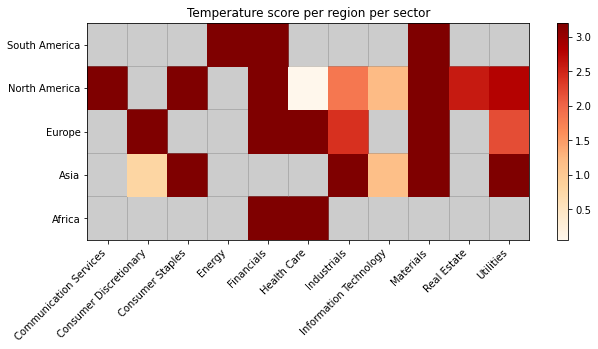

In [10]:
analysis_parameters = ([ETimeFrames.MID], [EScope.S1S2], grouping)
plot_grouped_heatmap(grouped_aggregations, analysis_parameters)

For example, we see that the Industrials in Asia perform worse than their counterparts in North America and Europe. We can zoom
in on the companies in this group and their relative contributions to the group's temperature score.

In [53]:
region =  'Asia'
sector = 'Industrials'
group = sector + '-' + region
group_contributions = get_contributions_per_group(grouped_aggregations, analysis_parameters, group)
group_contributions.style.hide_index()

group,company_name,company_id,temperature_score,contribution_relative
Industrials-Asia,"SUMITOMO CHEMICAL Co., Ltd.",JP3401400001,3.200000,33.333333
Industrials-Asia,Company G,CN0000000007,3.200000,33.333333
Industrials-Asia,Company AE,TH0000000031,3.200000,33.333333


## Sector analysis
Sector analysis may help us with bringing some clarity into our analysis from the heatmap above. In order to identify the companies that your portfolio would most benefit from engaging with, we can start with identifying the biggest contributing sectors to the portfolio's temperature score, as in our example below.

Contributions can be identified on an individual company level, as well as contributions from companies grouped by one of their characteristics, e.g. sector or region. The exact definitions of companies' contributions to the portfolio temperature scores depend on the selected aggregation method.

You can group companies on any categorical variable (e.g. sectors, countries, market cap buckets, investment strategies, etc)  you provide through your dataprovider, in this example in the Data_Provider_Example.xlsx imported above.

For our analysis we select one time-frame (MID) and one scope (S1+S2) and group the outcomes on sector and compare AUM to temperature score contribution. We also then display the sector temperature scores.

To change the time frame, replace the extension "MID" in ETimeFrames.MID (the first line) to SHORT or LONG.
To change the time frame, replace the extension "S1S2" in EScope.S1S2 (the second line) to S3 or S1S2S3.
To change the grouping, replace 'sector' (the third line) to the category variable you are interested in.

### Quick analysis
In this example we can see that Materials, Financials, Energy, Consumer Staples and the Communication sectors are all scoring above 3.0C. From the pie charts we can also see that Materials, Financials and Consumer Staples are contributing more to the temperature score than their weight in the portfolio.

In [12]:
time_frames = [ETimeFrames.MID]
scopes = [EScope.S1S2]
grouping = ['sector']
analysis_parameters = (time_frames, scopes, grouping)

temperature_score = TemperatureScore(time_frames=time_frames,
                                     scopes=scopes,
                                     grouping=grouping)
amended_portfolio = temperature_score.calculate(data_providers=[provider], portfolio=companies)
aggregated_portfolio = temperature_score.aggregate_scores(amended_portfolio)
company_contributions = collect_company_contributions(aggregated_portfolio, amended_portfolio, analysis_parameters)

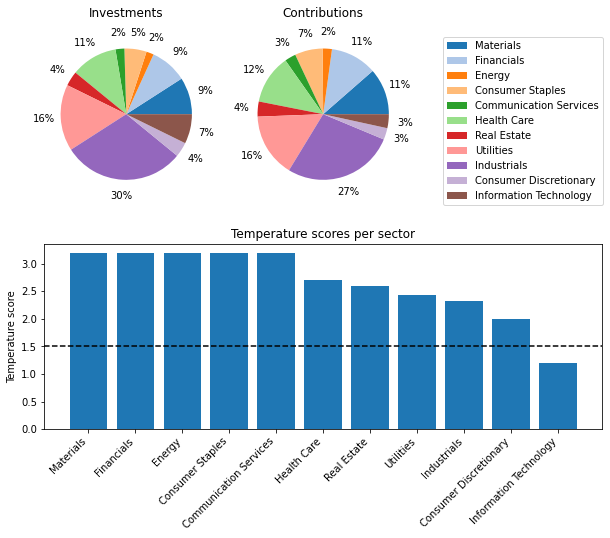

In [13]:
plot_grouped_statistics(aggregated_portfolio, company_contributions, analysis_parameters)

We can use what we learned from this analysis to drill into a few of the highest contributing scoring sectors to see which
companies are the biggest contributors on the sector level. Considering the health care sector, for instance, we see in the
table below that Company N is by far the largest contributor, and might therefore be a candidate to engage with.

In [55]:
sector_contributions = company_contributions[['company_name', 'company_id', 'sector', 'contribution', 'temperature_score', 'ownership_percentage', 'portfolio_percentage']]
sector_contributions.loc[sector_contributions['sector'] == 'Health Care'][:10].round(2).style.hide_index()

company_name,company_id,sector,contribution,temperature_score,ownership_percentage,portfolio_percentage
Company N,FR0000000014,Health Care,9.830000,3.200000,0.190000,7.820000
Company AD,KE0000000030,Health Care,2.290000,3.200000,0.010000,1.820000
CVS Health,US1266501006,Health Care,0.040000,0.050000,0.010000,1.820000


## Companies to engage with
In addition to statistics of the companies grouped by a given category, as we did with the sector analysis above, you can analyse the companies' individual contributions to the portfolio temperature score across the whole portfolio, as we have done below. Alternatively we can use the information we gathered above to do the below analysis for one of the identified sectors. To reiterate, the contribution column shows the contribution of a specific company to the overall portfolio temperature score. The computation of these contributions differs, in accordance with the aggregation methods explained above.

In this analysis we are also choosing to display temperature score, ownership and portfolio weight. Therefore, we can use this table to analyse which companies we may have a better chance of having a successful engagement with.
We show the top 10 contributing companies. To see more or fewer companies change the '10' near the end of the line in "[:10]".

### Quick analysis
In this case we are primarily looking at our ownership of the company in relation to the contribution to find companies which we may be able to influence and where our work will have an impact on our portfolio TS.

Company N has the biggest contribution to our TS, and even if we have a substantial position in our portfolio, we own a very small part of the company, so any engagement effort by just us may not be that successsful.

We may have better luck with Comapny Q where we own close to 5% of the company, and it is still a reasonably large position in our portfolio and if we are successful, it may have a bigger impact on our portfolio score than with for example company N.

Naturally, we can join other investors to influence Company N to convince them to set emission reduction targets. This contribution table gives you some of the information you need to make these decisions.

In [25]:
company_contributions[['company_name', 'company_id', 'contribution', 'temperature_score', 'ownership_percentage', 'portfolio_percentage']][:10].round(2).style.hide_index()

company_name,contribution,temperature_score,ownership_percentage,portfolio_percentage
Company N,9.830000,3.200000,0.190000,7.820000
"Advanced Micro Devices, Inc",4.580000,1.830000,0.330000,6.360000
Company Q,2.740000,3.200000,4.810000,2.180000
Dell Technologies,2.290000,3.200000,0.290000,1.820000
Company AE,2.290000,3.200000,0.210000,1.820000
Company I,2.290000,3.200000,0.330000,1.820000
Company AF,2.290000,3.200000,0.970000,1.820000
Company F,2.290000,3.200000,0.110000,1.820000
Capgemini Group,2.290000,3.200000,0.320000,1.820000
L'Oréal,2.290000,3.200000,0.400000,1.820000


## What-if analysis
To determine the effect of engaging (part of) your portfolio, you can run a number of scenarios:
 - 1: Engage companies to set 2 degree targets. This means that the score of all companies that didn't yet set a target will be set to 2 degrees celcius.
 - 2: Engage companies to set well below 2 degree targets. The maximum score for all companies that have set targets will be capped at 1.75 degrees celcius.
 - 3a: Engage the top 10 contributors to set 2 degree targets.
 - 3b: Engage the top 10 contributors to have set well below 2 degree targets. This means that the maximum score for all the targets of these companies will be capped at 1.75 degrees celcius.
 - 4a: Engage the predefined companies to set 2 degree targets.
 - 4b: Engage the predefined companies to set well below 2 degree targets. This means that the maximum score for all the targets of these companies will be capped at 1.75 degrees celcius.

In this example, we identified a couple of companies above where we think we can have some success in our engagement efforts. Next, we will therefore investigate the effect of engaging Company Q and Company AF in setting targets.

The cell below defines scenario 4a, which means that we manage to get the companies we engage with, to set GHG emission reduction targets that give them both a score of 2.0C. We will define the companies in the next cell below.
To change the scenario, replace the extension "HIGHEST_CONTRIBUTORS_APPROVED" in ScenarioType.HIGHEST_CONTRIBUTORS_APPROVED (the second line) to TARGETS (for scenario 1), APPROVED_TARGETS (scenario 2) or HIGHEST_CONTRIBUTORS (scenario 3). To differentiate between options a and b in scenario 3 and 4, change the extension "SET_TARGETS" in EngagementType.SET_TARGETS. Use "SET_TARGETS" for option a and "SET_SBTI_TARGETS" for option b. For scenarios 1 and 2 the choice here does not matter.
In the fourth and fifth lines the aggregation method and grouping are specified. You can change these the same way as in the previous sections.

In [26]:
scenario = Scenario()
scenario.scenario_type = ScenarioType.HIGHEST_CONTRIBUTORS_APPROVED
scenario.engagement_type = EngagementType.SET_TARGETS
scenario.aggregation_method = PortfolioAggregationMethod.WATS
scenario.grouping = 'sector'

### Portfolio temperature score impact
In our what-if analysis, we can now add Company Q and Company AF with company IDs CA0000000017 and ID0000000032 to to the companies which have set a target. Please note that our example portfolio file contains a column named "engagement_target". The companies with values of 1.0 in this column are included in this scenario. The cell below adds Company Q and Company AF to these other predefined companies in the portfolio, which were already marked for engagement.

You can add more companies to target by copying line 2 or 3 of the following cell and replacing the company ID by the ID of your selected company.

#### Quick analysis
As we can see below, the impact on our portfolio TS of engaging with the companies selected for engagement reduces our portfolio temperatures score from 2.55C to 2.41C.

In [27]:
scenario_portfolio = portfolio.copy()
scenario_portfolio['engagement_target'] = False
scenario_portfolio.loc[scenario_portfolio['company_id'] == 'CA0000000017', 'engagement_target'] = True
scenario_portfolio.loc[scenario_portfolio['company_id'] == 'ID0000000032', 'engagement_target'] = True

In [19]:
scenario_companies = [SBTi.interfaces.PortfolioCompany.parse_obj(company) for company in scenario_portfolio.to_dict(orient="records")]
scenario_data = SBTi.utils.get_data([provider], scenario_companies)

temperature_score.scenario = scenario
scenario_companies = SBTi.utils.dataframe_to_portfolio(scenario_portfolio)
scenario_scores = temperature_score.calculate(data_providers=[provider], portfolio=scenario_companies)
scenario_aggregated = temperature_score.aggregate_scores(scenario_scores)
print_scenario_gain(aggregated_portfolio, scenario_aggregated)

Actual portfolio temperature score
mid - S1S2: 2.55 degrees Celcius

Scenario portfolio temperature score
mid - S1S2: 2.41 degrees Celcius


### Sector temperature score impact
We can dig in a bit deeper into our analysis to identify changes in sector temperature scores.

In the two cell below we print the scenario effects on temperature score per sector and then display this data with pie charts and and a histogram.
The first block shows the scope 1 and 2 mid-term temperature scores per sector calculated with the current temperature scores. The second block shows the temperature scores of the same categories, but now based on the what-if scenario where the chosen companies have set 2 degree targets.

#### Quick analysis
The Energy, Consumer Staples and Communication sectors are no longer scoring above 3.0C. We still need to do some work in the Materials and Financials sector, to reduce these sector scores.

In [20]:
print("Actual temperature scores")
print_grouped_scores(aggregated_portfolio)
print("\n\nScenario temperature scores")
print_grouped_scores(scenario_aggregated)

Actual temperature scores

mid - S1S2
Communication Services: 3.20 degrees Celcius
Consumer Discretionary: 2.00 degrees Celcius
Consumer Staples: 3.20 degrees Celcius
Energy: 3.20 degrees Celcius
Financials: 3.20 degrees Celcius
Health Care: 2.70 degrees Celcius
Industrials: 2.33 degrees Celcius
Information Technology: 1.20 degrees Celcius
Materials: 3.20 degrees Celcius
Real Estate: 2.59 degrees Celcius
Utilities: 2.44 degrees Celcius


Scenario temperature scores

mid - S1S2
Communication Services: 2.00 degrees Celcius
Consumer Discretionary: 2.00 degrees Celcius
Consumer Staples: 2.80 degrees Celcius
Energy: 2.00 degrees Celcius
Financials: 3.20 degrees Celcius
Health Care: 2.70 degrees Celcius
Industrials: 2.25 degrees Celcius
Information Technology: 1.20 degrees Celcius
Materials: 3.20 degrees Celcius
Real Estate: 2.59 degrees Celcius
Utilities: 2.17 degrees Celcius


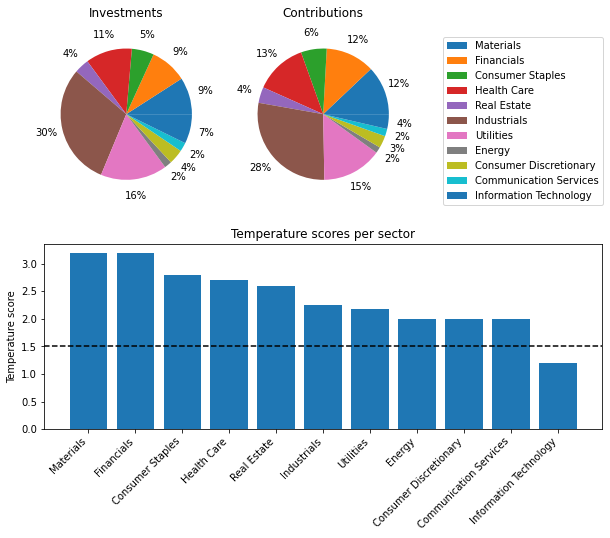

In [21]:
scenario_contributions = collect_company_contributions(scenario_aggregated, scenario_scores, analysis_parameters)
plot_grouped_statistics(scenario_aggregated, scenario_contributions, analysis_parameters)

## Company temperature score contribution impact
If our engagement is successful we can see that both Company Q and Company AF would disappear from from the list of biggest contributing companies to our TS.

In [29]:
scenario_contributions['temperature_score_change'] = scenario_contributions['temperature_score'] - company_contributions['temperature_score']
scenario_contributions['contribution_change'] = scenario_contributions['contribution'] - company_contributions['contribution']
largest_reductions = scenario_contributions[scenario_contributions['temperature_score_change'] != 0.0]
pd.concat([
    scenario_contributions[['company_name', 'contribution', 'contribution_change', 'temperature_score', 'temperature_score_change', 'ownership_percentage', 'portfolio_percentage']][:10],
    largest_reductions[['company_name', 'contribution', 'contribution_change', 'temperature_score', 'temperature_score_change', 'ownership_percentage', 'portfolio_percentage']]
]).round(2).style.hide_index()

,company_name,contribution,contribution_change,temperature_score,temperature_score_change,ownership_percentage,portfolio_percentage
0,Company N,10.38,0.55,3.20,0.00,0.19,7.82
1,"Advanced Micro Devices, Inc",4.83,0.26,1.83,0.00,0.33,6.36
15,"PepsiCo, Inc.",2.41,0.13,3.20,0.00,0.10,1.82
27,Company AD,2.41,0.13,3.20,0.00,0.01,1.82
26,Dell Technologies,2.41,0.13,3.20,0.00,0.29,1.82
25,Company AE,2.41,0.13,3.20,0.00,0.21,1.82
23,L'Oréal,2.41,0.13,3.20,0.00,0.40,1.82
22,Company AB,2.41,0.13,3.20,0.00,0.14,1.82
21,Capgemini Group,2.41,0.13,3.20,0.00,0.32,1.82
20,"SUMITOMO CHEMICAL Co., Ltd.",2.41,0.13,3.20,0.00,0.27,1.82


# Save your data for further analysis
To take your analysis outside of this notebook and for example for internal and client reporting, you can export all data to Excel and the clipboard for pasting into and analysing in other applications.

In order to store the portfolio and provider data locally, two options apply:
1. You are running the SBTi tool locally or from Google Colab
2. You are running the SBTi tool from a Docker container

If you run the SBTi tool locally or from Google Colab, you:
- Specify and filenames of the output files in the cell below
- Run the cell below

In [20]:
data_dump_filename = 'data_dump.xlsx'
amended_portfolio.to_excel(data_dump_filename, index=False)

If you run the SBTi tool locally, you finished the notebook at this point. If you run the SBTi tool from Google Colab, you:
- Click on the files icon in the left pane
- Click the three dots that appear after hovering over the file
- Download the file to your local machine

and you finished the notebook.

If you use the SBTi tool from a docker container:
- Run the cell below
- Open an Excel file
- Right-click an Excel cell and click 'paste' or select an Excel cell and press Ctrl+v
- Save the Excel file

You have then finished the notebook.

In [ ]:
amended_portfolio.to_clipboard(excel=True, index=False)